In [1]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import numpy as np
import IPython.display as ipd
from model.resnet import resnet152, resnet34

from utils.dataloader import CaptchaDataset

from sklearn.model_selection import train_test_split
import os

/home/moon/miniconda3/envs/torch/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# hyperparameter

In [2]:
EPOCHS = 1
CUDA = torch.cuda.is_available()
DEVICE = 'cuda:1' if CUDA else 'cpu'
MODEL_PATH = './weights/resnet34_ceal'
INIT_MODEL_PATH = './weights/resnet34_ceal_init'
BATCH_SIZE = 100
PATIENCE = 10

In [3]:
print(os.path.exists(INIT_MODEL_PATH))

True


In [4]:
INITIAL_ANNOTATED_PERCENT = 0.1
MAXIMUM_ITERATIONS = 30
THRESHOLD_DECAY = 0.0033
_DELTA = 0.05
UNCERTAIN_SAMPLES_SIZE = 10
UNCERTAIN_CRITERIA = 'lc'
COST_EFFECTIVE = True
FINE_TUNNING_INTERVAL = 1

# dataloader

In [5]:
image_transform = transforms.Compose([
    # transforms.Resize([224, 224]),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                      std=[0.229, 0.224, 0.225])
])

dataset = CaptchaDataset('/data/moon/datasets/Large_Captcha_Dataset', isFilter=True, isCrop=True)

In [6]:
print(len(dataset))

82328


In [7]:
pool_size = int(0.8 * len(dataset))
test_size = len(dataset) - pool_size
pool_dataset, test_dataset = torch.utils.data.random_split(dataset, [pool_size, test_size])

In [8]:
pool_size = int(0.9 * len(pool_dataset))
init_size = len(pool_dataset)-pool_size
pool_dataset, init_dataset = torch.utils.data.random_split(pool_dataset, [pool_size, init_size])

In [9]:
print(len(pool_dataset))
print(len(init_dataset))
print(len(test_dataset))

59275
6587
16466


In [10]:
pool_dataloader = DataLoader(pool_dataset, batch_size=BATCH_SIZE, shuffle=True)
init_dataloader = DataLoader(init_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [28]:
print(len(pool_dataloader.dataset))
print(len(init_dataloader.dataset))
print(len(test_dataloader.dataset))

59195
6667
16466


In [10]:
# x, y = next(iter(pool_dataloader)) # img, dict id

# model

In [11]:
# model = resnet34()

In [12]:
# if CUDA:
#     model = model.to(DEVICE)

# train

In [12]:
loss_history = []
val_loss_history = []

In [13]:
def train(model, train_dataloader):
    model.train()
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
    
    min_loss = 20.
    stop_cnt = 0
    for e in range(EPOCHS):
        start_time = time.time()
        current_loss = []
        current_val_loss = []

        for (x, y) in tqdm(train_dataloader): # train_loader = init_loader
            optimizer.zero_grad()
            x = x.to(DEVICE)
            y = y.to(DEVICE)

            y1, y2, y3, y4, y5 = y[:, 0], y[:, 1], y[:, 2], y[:, 3], y[:, 4]

            pred1, pred2, pred3, pred4, pred5 = model(x)

            loss1 = criterion(pred1, y1)
            loss2 = criterion(pred2, y2)
            loss3 = criterion(pred3, y3)
            loss4 = criterion(pred4, y4)
            loss5 = criterion(pred5, y5)
            loss = loss1 + loss2 + loss3 + loss4 + loss5
            current_loss.append(loss.item())
            loss.backward()
            optimizer.step()

        current_loss = np.mean(current_loss).item()
        loss_history.append(current_loss)

        if current_loss < min_loss:
            min_loss = current_loss
            torch.save(model.state_dict(), MODEL_PATH)

        # ipd.clear_output(wait=True)
        print(f"{e+1}/{EPOCHS}, {time.time()-start_time:.2f} sec/epoch")
        print(f"current loss={current_loss:.4f}")
        plt.figure(figsize=(20,1),dpi=120)
        plt.scatter(np.arange(len(loss_history)), loss_history, label='train')
        plt.legend(loc=1)
        plt.show()


# test

In [14]:
def evaluate(model, test_dataloader):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
    
    pred_list = [[] for i in range(5)]
    true_list = [[] for i in range(5)]
    current_loss = []

    for (x, y) in tqdm(test_dataloader):
        with torch.no_grad():
            x = x.to(DEVICE)
            y = y.to(DEVICE)

            y1, y2, y3, y4, y5 = y[:, 0], y[:, 1], y[:, 2], y[:, 3], y[:, 4]

            pred1, pred2, pred3, pred4, pred5 = model(x)
            
            loss1 = criterion(pred1, y1)
            loss2 = criterion(pred2, y2)
            loss3 = criterion(pred3, y3)
            loss4 = criterion(pred4, y4)
            loss5 = criterion(pred5, y5)
            loss = loss1 + loss2 + loss3 + loss4 + loss5
            current_loss.append(loss.item())
            
            
            pred1 = torch.argmax(pred1, -1)
            pred2 = torch.argmax(pred2, -1)
            pred3 = torch.argmax(pred3, -1)
            pred4 = torch.argmax(pred4, -1)
            pred5 = torch.argmax(pred5, -1)
            

            pred_list[0] += pred1.detach().cpu().tolist()
            pred_list[1] += pred2.detach().cpu().tolist()
            pred_list[2] += pred3.detach().cpu().tolist()
            pred_list[3] += pred4.detach().cpu().tolist()
            pred_list[4] += pred5.detach().cpu().tolist()

            true_list[0] += y1.detach().cpu().tolist()
            true_list[1] += y2.detach().cpu().tolist()
            true_list[2] += y3.detach().cpu().tolist()
            true_list[3] += y4.detach().cpu().tolist()
            true_list[4] += y5.detach().cpu().tolist()
            
    pred_list = np.array(pred_list)
    true_list = np.array(true_list)

    loss = np.mean(current_loss).item()
    accuracy = np.sum(pred_list==true_list, axis=1)/true_list.shape[-1]
    
    return loss, accuracy

# CEAL

In [15]:
def initialize_model(init_dataloader, test_dataloader):
    model = resnet34()
    if CUDA:
        model = model.to(DEVICE)
    if os.path.exists(INIT_MODEL_PATH):
        model.load_state_dict(torch.load(INIT_MODEL_PATH))
    else:
        train(model, init_dataloader)
        torch.save(model.state_dict(), INIT_MODEL_PATH)
    # print('Eval Init Model')
    # loss, acc = evaluate(model, test_dataloader)
    # print('Initial Test Loss: ', loss, '\nInitial Test Accuracy: ', acc)
    print('Model Initialization Complete')
    return model

In [16]:
# Random sampling
def random_sampling(y_pred_prob, n_samples):
    return np.random.choice(range(len(y_pred_prob)), n_samples)

In [17]:
# Rank all the unlabeled samples in an ascending order according to the least confidence
def least_confidence(y_pred_prob, n_samples):
    origin_index = np.arange(0, len(y_pred_prob)) # (4, 5, 62) len => 4 [0, 1, 2, 3]
    max_prob = np.max(y_pred_prob, axis=1) # (4, 62)
    
    # print('max_prob: ', max_prob) # max 
    
    pred_label = np.argmax(y_pred_prob, axis=1) # 어떤 단어가 가장 유력한가 (4, 62)
    
    # print('pred_label: ', pred_label)
    
    lci = np.column_stack((origin_index,
                           max_prob,
                           pred_label)) # 
    
    # print('lci.shape', lci.shape) # (4, 125)

    lci = lci[lci[:, 1].argsort()]
    # print('lci.shape: ', lci.shape)
    return lci[:n_samples], lci[:, 0].astype(int)[:n_samples]

In [18]:
# origin_index = np.arange(0,4)
# max_prob = np.arange(4*62).reshape(4,62)
# pred_label = np.arange(4*62).reshape(4,62)
# lci = np.column_stack((origin_index, max_prob, pred_label))
# # print(lci)
# # print(lci[:,1])
# lci[lci[:, 1].argsort()] # 확률값이 낮은 순서대로 정렬함
# lci[:n_samples], lci[:, 0].astype(int)[:n_samples] # (sample, index)

In [19]:
# Rank all the unlabeled samples in an ascending order according to the margin sampling
def margin_sampling(y_pred_prob, n_samples):
    origin_index = np.arange(0, len(y_pred_prob))
    margim_sampling = np.diff(-np.sort(y_pred_prob)[:, ::-1][:, :2])
    pred_label = np.argmax(y_pred_prob, axis=1)
    msi = np.column_stack((origin_index,
                           margim_sampling,
                           pred_label))
    msi = msi[msi[:, 1].argsort()]
    return msi[:n_samples], msi[:, 0].astype(int)[:n_samples]

In [20]:
# Rank all the unlabeled samples in an descending order according to their entropy
def entropy(y_pred_prob, n_samples):
    # entropy = stats.entropy(y_pred_prob.T)
    # entropy = np.nan_to_num(entropy)
    origin_index = np.arange(0, len(y_pred_prob))
    entropy = -np.nansum(np.multiply(y_pred_prob, np.log(y_pred_prob)), axis=1)
    pred_label = np.argmax(y_pred_prob, axis=1)
    eni = np.column_stack((origin_index,
                           entropy,
                           pred_label))

    eni = eni[(-eni[:, 1]).argsort()]
    return eni[:n_samples], eni[:, 0].astype(int)[:n_samples]

In [21]:
def get_high_confidence_samples(y_pred_prob, delta):
    eni, eni_idx = entropy(y_pred_prob, len(y_pred_prob))
    hcs = eni[eni[:, 1] < delta]
    return hcs[:, 0].astype(int), hcs[:, 2].astype(int)

In [22]:
def get_uncertain_samples(y_pred_prob, n_samples, criteria):
    if criteria == 'lc':
        return least_confidence(y_pred_prob, n_samples)
    elif criteria == 'ms':
        return margin_sampling(y_pred_prob, n_samples)
    elif criteria == 'en':
        return entropy(y_pred_prob, n_samples)
    elif criteria == 'rs':
        return None, random_sampling(y_pred_prob, n_samples)
    else:
        raise ValueError(
            'Unknown criteria value \'%s\', use one of [\'rs\',\'lc\',\'ms\',\'en\']' % criteria)

In [23]:
# model = resnet34().to(DEVICE)
# shape_type_list = []
# for i in range(1): # MAX_ITER = 30
#     y_pred_probs = None
#     for i, (x, y) in enumerate(pool_dataloader): # Pool_Size 14819
#         x = x.to(DEVICE)
#         y_pred_prob = model(x) 

#         y_pred_prob = np.array(list(map(lambda _y: (nn.functional.softmax(_y, dim=-1)).detach().cpu().numpy(), y_pred_prob))) # (5,4,62)
        

#         y_pred_prob = y_pred_prob.transpose((1,0,2)) # FROM (5, 4, 62) TO (4, 5, 62)
        
#         if i == 0:
#             y_pred_probs = y_pred_prob
#             pass
        
#         y_pred_probs = np.concatenate((y_pred_probs, y_pred_prob))
    
#     print(y_pred_probs.shape)
#     fin_output = y_pred_probs
        
#     # y_pred_probs = np.transpose(y_pred_probs, (0, 2, 1, 3)).reshape(-1, 5, 62) # (4, 5, 62)
#     # y_pred_probs = np.array(y_pred_probs)
#     # y_pred_probs = np.transpose(y_pred_probs, (0, 2, 1, 3)).reshape(-1, 5, 62)


In [24]:
# print(init_dataloader.sampler.data_source.indices.extend([123423141234]))

In [25]:
# print(init_dataloader.sampler.data_source.indices[0])

In [26]:
def run_ceal():
    model = initialize_model(init_dataloader, test_dataloader)
    _DELTA = 0.05
    
    print('run_ceal')
    
    for i in range(MAXIMUM_ITERATIONS): # MAX_ITER = 30
        for (x, y) in pool_dataloader: # Pool_Size 14819
            y_pred_probs = []
            x = x.to(DEVICE)
            y_pred_prob = model(x)
            y_pred_prob = list(map(lambda _y: (nn.functional.softmax(_y, dim=-1)).detach().cpu().numpy(), y_pred_prob))
            # y_pred_prob = y_pred_prob.detach().cpu().numpy()
            y_pred_probs.append(y_pred_prob)

            # break
            y_pred_probs = np.array(y_pred_probs)
            y_pred_probs = np.transpose(y_pred_probs, (0, 2, 1, 3)).reshape(-1, 5, 62) # (4, 5, 62)
            
            # print('y_pred_probs.shape : ', y_pred_probs.shape)

            _, un_idx = get_uncertain_samples(y_pred_probs, UNCERTAIN_SAMPLES_SIZE, criteria=UNCERTAIN_CRITERIA) 
            
            print('un_idx1 : ', un_idx) # lc => [3]
            # break
            un_idx = [pool_dataloader.sampler.data_source.indices[idx] for idx in un_idx]
            print('un_idx2 : ', un_idx)

            print('init_dataloader length1', len(init_dataloader.dataset))
            init_dataloader.sampler.data_source.indices.extend(un_idx)            
            print('init_dataloader length2', len(init_dataloader.dataset))
            # break

            if COST_EFFECTIVE:
                hcs_idx, hcs_labels = get_high_confidence_samples(y_pred_prob, _DELTA)

                hcs_idx = [pool_dataloader.sampler.data_source.indices[idx] for idx in hcs_idx]

                hcs_idx = [x for x in hcs_idx if x not in list(set(un_idx) & set(hcs_idx))]

                init_dataloader.sampler.data_source.indices.extend(hcs_idx)

                print('init_dataloader length3', len(init_dataloader.dataset))

                for idx in range(len(hcs_idx)):
                    init_dataloader.dataset.dataset.dataset.y[hcs_idx[idx]] = hcs_labels[idx]

            if i % FINE_TUNNING_INTERVAL == 0 : # finetuning interval = 1
                print('fine-tune interval', FINE_TUNNING_INTERVAL)
                train(model, init_dataloader) # init_dataloader에 uncertain 샘플 추가해서 돌림
                _DELTA -= (THRESHOLD_DECAY * FINE_TUNNING_INTERVAL)
                
            print('pool_dataloader length1', len(pool_dataloader.dataset))
            for val in un_idx:
                pool_dataloader.sampler.data_source.indices.remove(val)
            print('pool_dataloader length2', len(pool_dataloader.dataset))

        print('run eval')
        _, acc = evaluate(model, test_dataloader)

        print(
            "Iteration: {}, len(dl): {}, len(du): {},"
            " len(dh) {}, acc: {} ".format(
                i, len(init_dataloader.sampler.data_source.indices),
                len(pool_dataloader.sampler.data_source.indices), len(hcs_idx), acc))



Model Initialization Complete
run_ceal
un_idx1 :  [41 60  5 99 29 25 10  3 28 76]
un_idx2 :  [28554, 41493, 49239, 34190, 31821, 37648, 5856, 16673, 47862, 10527]
init_dataloader length1 6587
init_dataloader length2 6597
init_dataloader length3 6597
fine-tune interval 1


100%|██████████| 66/66 [00:23<00:00,  2.82it/s]

1/1, 23.53 sec/epoch
current loss=19.1544


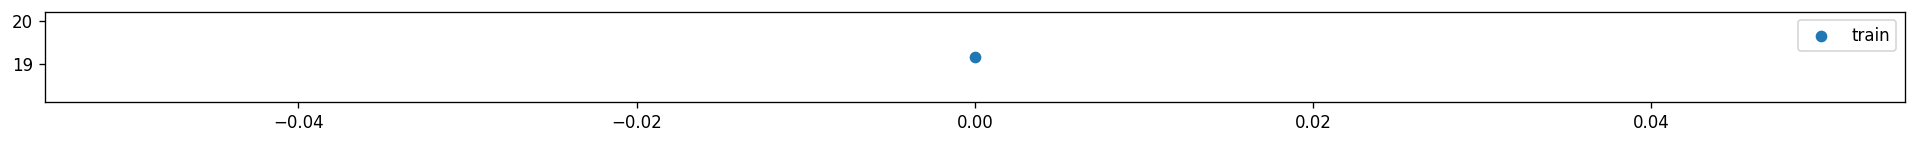

pool_dataloader length1 59275
pool_dataloader length2 59265
un_idx1 :  [48 99 40  1 34 22 70 19 46 24]
un_idx2 :  [4630, 20810, 28016, 59258, 1369, 36561, 44746, 45372, 60514, 53829]
init_dataloader length1 6597
init_dataloader length2 6607
init_dataloader length3 6607
fine-tune interval 1


100%|██████████| 67/67 [00:23<00:00,  2.85it/s]


1/1, 23.65 sec/epoch
current loss=19.1501


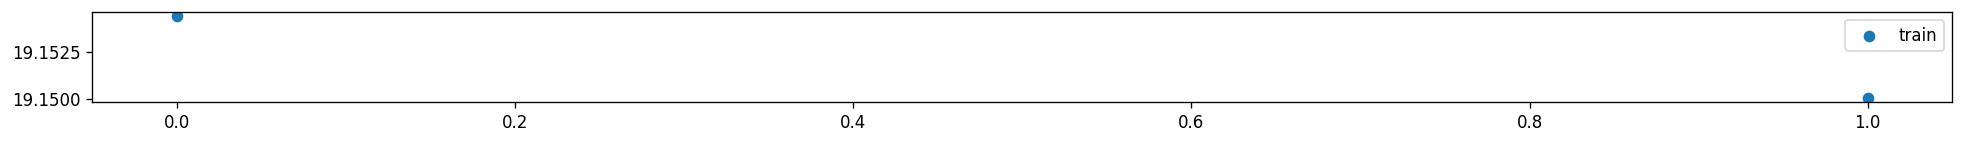

pool_dataloader length1 59265
pool_dataloader length2 59255
un_idx1 :  [41 25 46 22  9 30 67 13 87 59]
un_idx2 :  [45495, 36935, 39594, 43813, 29327, 57315, 22254, 29217, 28899, 6647]
init_dataloader length1 6607
init_dataloader length2 6617
init_dataloader length3 6617
fine-tune interval 1


100%|██████████| 67/67 [00:23<00:00,  2.84it/s]


1/1, 23.67 sec/epoch
current loss=19.1317


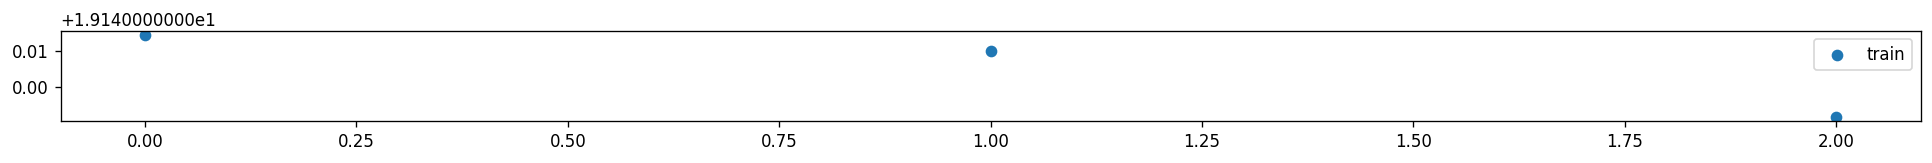

pool_dataloader length1 59255
pool_dataloader length2 59245
un_idx1 :  [40 21 47 71 37 19 98 49 31 58]
un_idx2 :  [9062, 40699, 13585, 34025, 1325, 57103, 13243, 38950, 28259, 337]
init_dataloader length1 6617
init_dataloader length2 6627
init_dataloader length3 6627
fine-tune interval 1


100%|██████████| 67/67 [00:23<00:00,  2.84it/s]


1/1, 23.69 sec/epoch
current loss=19.1306


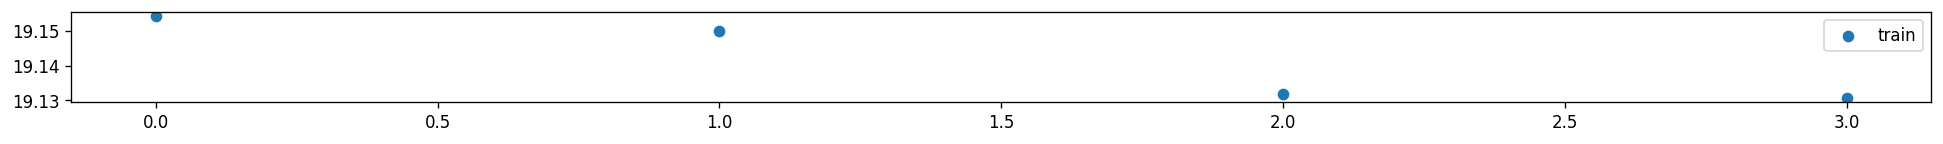

pool_dataloader length1 59245
pool_dataloader length2 59235
un_idx1 :  [82 47 40 42 86  8 70 19  5 96]
un_idx2 :  [61478, 34240, 34199, 26278, 30637, 18642, 59661, 46379, 62274, 14090]
init_dataloader length1 6627
init_dataloader length2 6637
init_dataloader length3 6637
fine-tune interval 1


100%|██████████| 67/67 [00:23<00:00,  2.82it/s]


1/1, 23.88 sec/epoch
current loss=19.1295


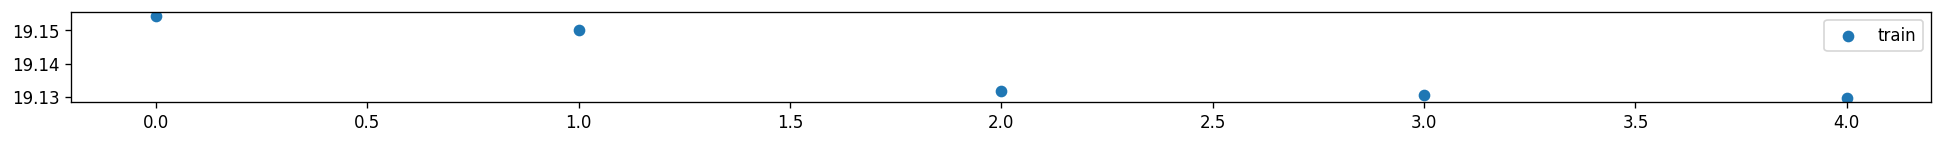

pool_dataloader length1 59235
pool_dataloader length2 59225
un_idx1 :  [14 66 76 18  9 34 77 95 36  7]
un_idx2 :  [42619, 29750, 61591, 62224, 29476, 65051, 21741, 59353, 7891, 53659]
init_dataloader length1 6637
init_dataloader length2 6647
init_dataloader length3 6647
fine-tune interval 1


100%|██████████| 67/67 [00:23<00:00,  2.83it/s]


1/1, 23.78 sec/epoch
current loss=19.1251


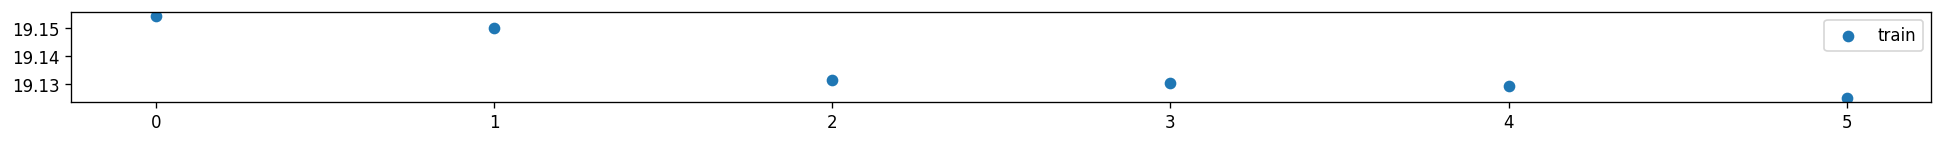

pool_dataloader length1 59225
pool_dataloader length2 59215
un_idx1 :  [68 13 63 76 49 32 24 83 16 20]
un_idx2 :  [15396, 19686, 39919, 3330, 23605, 62679, 55271, 62853, 59741, 8880]
init_dataloader length1 6647
init_dataloader length2 6657
init_dataloader length3 6657
fine-tune interval 1


100%|██████████| 67/67 [00:23<00:00,  2.82it/s]


1/1, 23.85 sec/epoch
current loss=19.1301


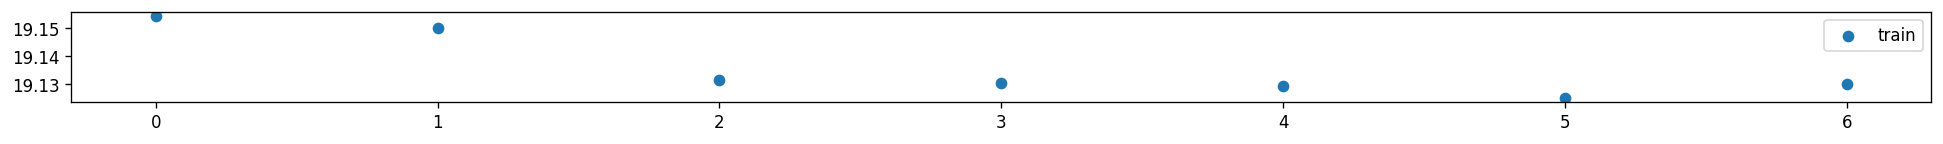

pool_dataloader length1 59215
pool_dataloader length2 59205
un_idx1 :  [ 2 14 88 80 16 37 79 63 61 17]
un_idx2 :  [30156, 16304, 49373, 48974, 54339, 56577, 28134, 17315, 9928, 45478]
init_dataloader length1 6657
init_dataloader length2 6667
init_dataloader length3 6667
fine-tune interval 1


100%|██████████| 67/67 [00:23<00:00,  2.82it/s]

1/1, 23.89 sec/epoch
current loss=19.1327


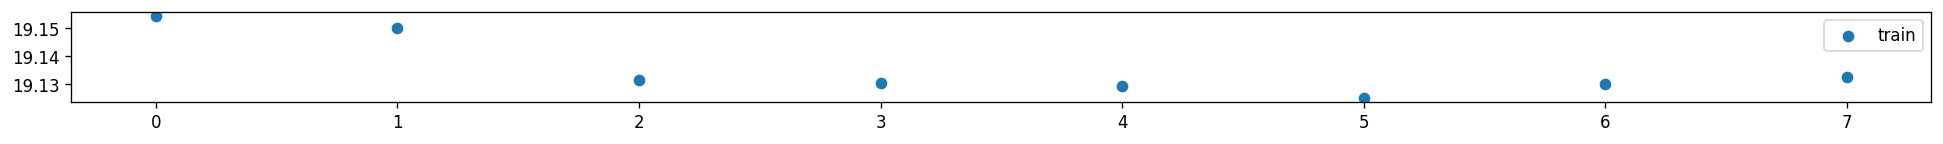

pool_dataloader length1 59205
pool_dataloader length2 59195


IndexError: list index out of range

In [27]:
run_ceal()

In [ ]:
Iteration: 2, len(dl): 6599, len(du): 59263, len(dh) 0, acc: [0.57955788 0.42754767 0.37592615 0.40714199 0.5447589 ] 
functional

# visalization

In [33]:
keys = "0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ"

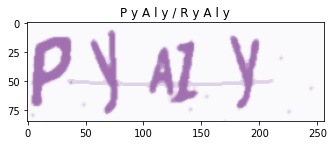

In [49]:
for (x, y) in test_dataloader:
    with torch.no_grad():
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        y1, y2, y3, y4, y5 = y[:, 0], y[:, 1], y[:, 2], y[:, 3], y[:, 4]

        pred1, pred2, pred3, pred4, pred5 = model(x)
        pred1 = torch.argmax(pred1, -1)
        pred2 = torch.argmax(pred2, -1)
        pred3 = torch.argmax(pred3, -1)
        pred4 = torch.argmax(pred4, -1)
        pred5 = torch.argmax(pred5, -1)
        
        y1 = list(map(lambda x: keys[x], y1))
        y2 = list(map(lambda x: keys[x], y2))
        y3 = list(map(lambda x: keys[x], y3))
        y4 = list(map(lambda x: keys[x], y4))
        y5 = list(map(lambda x: keys[x], y5))
        
        pred1 = list(map(lambda x: keys[x], pred1))
        pred2 = list(map(lambda x: keys[x], pred2))
        pred3 = list(map(lambda x: keys[x], pred3))
        pred4 = list(map(lambda x: keys[x], pred4))
        pred5 = list(map(lambda x: keys[x], pred5))
        
        
        for idx in range(BATCH_SIZE):
            true_str = f'{y1[idx]} {y2[idx]} {y3[idx]} {y4[idx]} {y5[idx]}'
            pred_str = f'{pred1[idx]} {pred2[idx]} {pred3[idx]} {pred4[idx]} {pred5[idx]}'
            plt.figure(figsize=(50,50))
            plt.subplot(8, 8, idx+1)
            plt.title(f'{true_str} / {pred_str}')
            plt.imshow(x[idx].detach().cpu().permute(1, 2, 0))
        break